This notebook aims to take a set of images of X-Ray exams of pacients with and without Covid-19 and then train a Convolutional Neural Netwok applying Transfer Learning to detect covid. Results show an accuracy greater than 90% on both train and validation datasets.

In [20]:
# libs
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models, optimizers, utils
import PIL
import time
import matplotlib.pyplot as plt

# Set up

In [2]:
# download and unzip the images from a Google Drive repository
!gdown --id 1gcQmEpqYE658_xyetCrAZyO4w1XYqBEd
!unzip covid.zip

Downloading...
From: https://drive.google.com/uc?id=1gcQmEpqYE658_xyetCrAZyO4w1XYqBEd
To: /content/covid.zip
100% 874M/874M [00:08<00:00, 104MB/s]
Archive:  covid.zip
   creating: covid/
   creating: covid/train/
   creating: covid/train/covid/
  inflating: covid/train/covid/000001-1.jpg  
  inflating: covid/train/covid/000001-1.png  
  inflating: covid/train/covid/000001-10.jpg  
  inflating: covid/train/covid/000001-11.jpg  
  inflating: covid/train/covid/000001-12.jpg  
  inflating: covid/train/covid/000001-13.jpg  
  inflating: covid/train/covid/000001-14.jpg  
  inflating: covid/train/covid/000001-15.jpg  
  inflating: covid/train/covid/000001-17.jpg  
  inflating: covid/train/covid/000001-18.jpg  
  inflating: covid/train/covid/000001-19.jpg  
  inflating: covid/train/covid/000001-2.jpg  
  inflating: covid/train/covid/000001-20.jpg  
  inflating: covid/train/covid/000001-24.jpg  
  inflating: covid/train/covid/000001-266.jpg  
  inflating: covid/train/covid/000001-27.jpg  
  inf

In [4]:
# Hyperparameters
IMAGE_SIZE = [150, 150]
EPOCHS = 100
CLASSES = 2
BATCH_SIZE = 32
INPUT_SHAPE = (150, 150, 3)
random_state = 42
alpha = 1e-5

In [5]:
# train and validation directories
train_dir = 'covid/train'
validation_dir = 'covid/validation'

## Loading images with Keras

### Data Augmentation
Data augmentation is a technique that creates small distortions on original images so the model can learn what is really essential and avoid overfitting

In [6]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    fill_mode = 'nearest'
)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = True
)

Found 1200 images belonging to 2 classes.


In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    shuffle = False
)

Found 258 images belonging to 2 classes.


## Imagery Display

In [21]:
train_ds = utils.image_dataset_from_directory(
  train_dir,
  image_size=IMAGE_SIZE
)

Found 1200 files belonging to 2 classes.
Found 258 files belonging to 2 classes.


### X-rays with Covid 

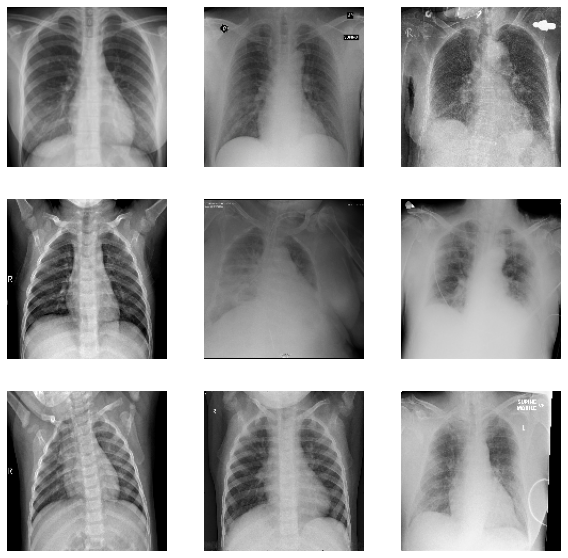

In [19]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

### X-rays without Covid 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


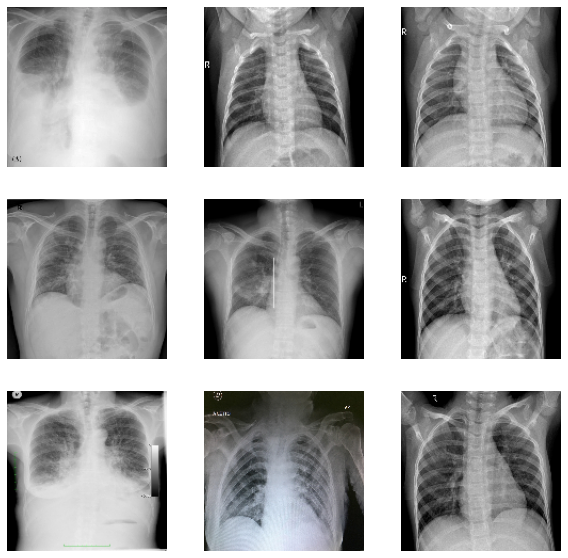

In [22]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

# Transfer Learning with VGG19

We'll get the VGG19 network to use transfer learning technique. Our model will use the weights previously trained on ImageNet, excepted by the last 5. These layers will then be trained with our set of images to learn their particularities.

In [23]:
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

80150528/80134624 [==============================] - 1s 0us/step


In [24]:
# Freezing all layers except the last five
conv_base.trainable = True

for i, layer in enumerate(conv_base.layers[:-5]):
  layer.trainable = False

In [25]:
# Define model architecture. A simple architecture will do the job, since we are using the VGG19 structure
model = models.Sequential()
model.add(conv_base) # VGG19
model.add(layers.GlobalAveragePooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(CLASSES, activation='softmax'))

In [26]:
# model compilation:
model.compile(
    loss='binary_crossentropy',
    optimizer = 'adam',
    metrics = ['acc']
)

In [27]:
# Callbacks definition
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

filename = 'checkpoint'

# model checkpoint to save the configuration of the best results
checkpoint = ModelCheckpoint(filename, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# learning rate reduction to improve results when the loss function becomes stagnant
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=1e-1, min_delta=alpha, patience=10, verbose=1)
# earlt stopping to avoid overfitting when the model reachs a plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-3, restore_best_weights=True)

callbacks = [checkpoint, lr_reduce, early_stopping]

In [28]:
# training
history = model.fit(
    train_generator,
    epochs = EPOCHS,
    shuffle = True,
    verbose=2,
    validation_data = validation_generator,
    callbacks = callbacks
)

Epoch 1/100

Epoch 00001: val_acc improved from -inf to 0.60078, saving model to checkpoint
INFO:tensorflow:Assets written to: checkpoint/assets
38/38 - 55s - loss: 0.2264 - acc: 0.9200 - val_loss: 4.6964 - val_acc: 0.6008 - lr: 0.0010 - 55s/epoch - 1s/step
Epoch 2/100

Epoch 00002: val_acc did not improve from 0.60078
38/38 - 40s - loss: 0.0585 - acc: 0.9808 - val_loss: 8.3078 - val_acc: 0.5000 - lr: 0.0010 - 40s/epoch - 1s/step
Epoch 3/100

Epoch 00003: val_acc improved from 0.60078 to 0.94574, saving model to checkpoint
INFO:tensorflow:Assets written to: checkpoint/assets
38/38 - 44s - loss: 0.0391 - acc: 0.9858 - val_loss: 0.1857 - val_acc: 0.9457 - lr: 0.0010 - 44s/epoch - 1s/step
Epoch 4/100

Epoch 00004: val_acc did not improve from 0.94574
38/38 - 40s - loss: 0.0500 - acc: 0.9783 - val_loss: 10.3121 - val_acc: 0.5000 - lr: 0.0010 - 40s/epoch - 1s/step
Epoch 5/100

Epoch 00005: val_acc did not improve from 0.94574
38/38 - 40s - loss: 0.0460 - acc: 0.9833 - val_loss: 2.1311 - val

In [30]:
model.save('/content/covid.h5')

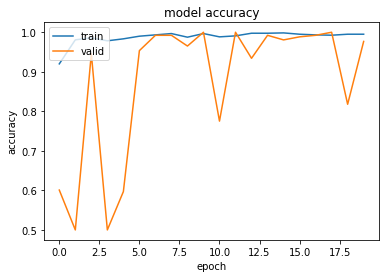

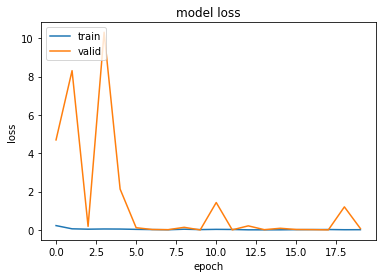

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

From plots above we can notice that our model reached ~99% accuracy on both train and validation data. Transfer Learning is really an amazing technique that can help us achieve amazing results without the need to hold a lot of computational resources.